# Project 4: An analysis of Friends, using NLP and Unsupervised Learning

## Imports

In [1]:
import pandas as pd
import numpy as np
import nltk

import re
import string

#from nltk.tokenize import TreebankWordTokenizer
#from nltk.stem import PorterStemmer
from nltk import word_tokenize, pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer 
#from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

## Importing the CSV

In [2]:
friends = pd.read_csv('Full_Friends_Transcript.csv')

In [3]:
friends.drop('Unnamed: 0', axis=1, inplace=True)

In [245]:
friends

quote  season  episode_number
0    There's nothing to tell! He's just some guy I ...     1.0             1.0
1    What you guys don't understand is, for us, kis...     1.0             2.0
2    (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...     1.0             3.0
3    Alright. Phoebe? Okay, okay. If I were omnipot...     1.0             4.0
4    Would you let it go? It's not that big a deal....     1.0             5.0
..                                                 ...     ...             ...
229  Hi Hey! Hi! How was the honeymoon? Phoebe; Oh,...    10.0            13.0
230  (raising his glass) Thank you guys for having ...    10.0            14.0
231  Previously on Friends... How did the job stuff...    10.0            15.0
232  All right, all right, all right, let's play on...    10.0            16.0
233  Previously on Friends. Erica, are you okay? Ye...    10.0            17.0

[234 rows x 3 columns]

## Cleaning Functions and Other


Keeping Only Nouns

In [4]:
def nouns(string):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    nouns = lambda x: x[:2] == 'NN'
    tokenized = word_tokenize(string)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if nouns(pos)] 
    return ' '.join(all_nouns)

Cleaning function to:
- remove numbers and words surrounding them
- remove punctuation and lowercase
- remove paranthesis and words inside
- remove brackets and words inside
- change any versions of aaahhhh (however many a's and h's) to 'ahh'

In [5]:
def cleaning_function(corpus):
    alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())
    no_paranth = lambda x: re.sub('\(.*?\)', '', x)
    no_bracket = lambda x: re.sub('\[.*?\]', '', x)
    aah = lambda x: re.sub('[a]+[h]+', 'aah', x)
    corpus = corpus.map(no_paranth).map(no_bracket).map(alphanumeric).map(punc_lower).map(aah).map(nouns)
    return corpus

Split dataframe into one with just the quotes to clean and vectorize and one with the meta-data

In [6]:
friends_quotes = friends['quote']

In [7]:
friends_meta = friends[['season', 'episode_number']]

In [8]:
friends_quotes

0      There's nothing to tell! He's just some guy I ...
1      What you guys don't understand is, for us, kis...
2      (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...
3      Alright. Phoebe? Okay, okay. If I were omnipot...
4      Would you let it go? It's not that big a deal....
                             ...                        
229    Hi Hey! Hi! How was the honeymoon? Phoebe; Oh,...
230    (raising his glass) Thank you guys for having ...
231    Previously on Friends... How did the job stuff...
232    All right, all right, all right, let's play on...
233    Previously on Friends. Erica, are you okay? Ye...
Name: quote, Length: 234, dtype: object

Clean the quotes with the cleaning function above

In [9]:
friends_clean = cleaning_function(friends_quotes)

In [10]:
friends_clean

0      theres nothing hes guy work youre guy somethin...
1      understand part yeaah everything i opening act...
2      hi guys hi hey howd subway right uh language g...
3      phoebe okay i day i world peace things rainfor...
4      deal deal ok maneuver bra sleeve im nothing gu...
                             ...                        
229    hi hey honeymoon phoebe champagne candlelit di...
230    thank yeaah couples night yeaah i couples time...
231    friends job stuff bottle israels job god pleas...
232    lets time ok im youre joe rules tails ha tails...
233    friends i stomachaches minutes god antacids st...
Name: quote, Length: 234, dtype: object

## First Attempt at Vectorizing (and Modeling) with just words

In [11]:
from nltk.corpus import stopwords

Creating a larger stopwords list by adding to the original one

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
new_stop_words = ['aand', 'oh', 'like', 'ok', 'okay', 'hey', 'just', 'yeaah', 'right', 
                  'monica', 'joey', 'rachel', 'chandler', 'phoebe', 'ross', 'im', 
                 'youre', 'hes', 'shes', 'thats', 'dont', 'ill', 'ii', 'janice', 'richard', 
                 'mike', 'emma', 'emily', 'david', 'julie', 'mark',  'julies', 'saraah', 
                 'cmon', 'ya', 'uh', 'lets', 'whats', 'ow', 'aah', 'yknow', 'anything', 
                 'nothing', 'know', 'guys', 'things', 'marcel', 'barry', 'theres', 'didnt', 'bye', 'paul', 'blaah',
                 'woaah', 'jill', 'cat', 'chip', 'doctor', 'ring', 'joshua', 'lauren', 'alice', 'frank',
                 'ben', 'monkey', 'carol', 'apartment', 'lot', 'hooker', 'tape', 'tattoo', 'umm', 'ohh', 'kathy', 
                 'huh', 'um', 'cant', 'ive', 'whatre', 'theyre', 'phoebs', 'wanna', 'uhm', 'charlie', 'alright', 
                 'id', 'mikes', 'dr', 'amy', 'pheebs', 'stuff', 'tulsa', 'isnt', 'doesnt', 'whos', 'fine', 'youve', 
                 'wont', 'still', 'paolo', 'la', 'mindy', 'eddie', 'annulment', 'ralph', 'cause', 'big', 'ever', 
                 'get', 'getting', 'bob', 'susan', 'drake', 'nice', 'please', 'toe', 'dog', 'move', 'keys', 
                 'live', 'moving', 'gon']

In [14]:
stopwords = list(stop_words) + new_stop_words

Using TF-IDF on the corpus 

In [15]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=.01, max_df=.9)

In [16]:
friends_tfidf = tfidf.fit_transform(friends_clean)

In [17]:
friends_tfidf

<234x3093 sparse matrix of type '<class 'numpy.float64'>'
	with 42133 stored elements in Compressed Sparse Row format>

In [18]:
friends_num = pd.DataFrame(friends_tfidf.toarray(), columns=tfidf.get_feature_names())

In [19]:
friends_num

aaand  aaha  aahaah    aahead  aaron  aasen  ability  accent  access  \
0      0.0   0.0     0.0  0.042139    0.0    0.0      0.0     0.0     0.0   
1      0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
2      0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
3      0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
4      0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
..     ...   ...     ...       ...    ...    ...      ...     ...     ...   
229    0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
230    0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
231    0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
232    0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   
233    0.0   0.0     0.0  0.000000    0.0    0.0      0.0     0.0     0.0   

     accident  ...  youreyoure  youyou  youyoure  youyouyou      ysee  yuck  \
0         0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
1         0.0  ...    0.000000     0.0       0.0        0.0  0.082513   0.0   
2         0.0  ...    0.065054     0.0       0.0        0.0  0.000000   0.0   
3         0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
4         0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
..        ...  ...         ...     ...       ...        ...       ...   ...   
229       0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
230       0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
231       0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
232       0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   
233       0.0  ...    0.000000     0.0       0.0        0.0  0.000000   0.0   

     yummy    zelner  zone  zoo  
0      0.0  0.000000   0.0  0.0  
1      0.0  0.000000   0.0  0.0  
2      0.0  0.000000   0.0  0.0  
3      0.0  0.000000   0.0  0.0  
4      0.0  0.000000   0.0  0.0  
..     ...       ...   ...  ...  
229    0.0  0.000000   0.0  0.0  
230    0.0  0.000000   0.0  0.0  
231    0.0  0.127876   0.0  0.0  
232    0.0  0.000000   0.0  0.0  
233    0.0  0.000000   0.0  0.0  

[234 rows x 3093 columns]

Modeling with NMF

In [20]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(friends_tfidf)

In [21]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             columns = tfidf.get_feature_names())
topic_word

aaand   aaha  aahaah  aahead  aaron  aasen  ability  accent  access  \
0   0.02  0.014   0.005   0.012  0.000  0.031    0.000   0.037   0.016   
1   0.00  0.000   0.005   0.002  0.016  0.016    0.000   0.017   0.003   
2   0.00  0.003   0.000   0.005  0.026  0.038    0.000   0.004   0.000   
3   0.00  0.000   0.004   0.009  0.000  0.010    0.016   0.000   0.000   
4   0.02  0.000   0.000   0.006  0.000  0.004    0.000   0.000   0.001   

   accident  ...  youreyoure  youyou  youyoure  youyouyou   ysee   yuck  \
0     0.032  ...       0.020   0.064     0.006      0.015  0.006  0.007   
1     0.007  ...       0.000   0.025     0.015      0.000  0.000  0.000   
2     0.005  ...       0.006   0.024     0.005      0.018  0.003  0.009   
3     0.023  ...       0.008   0.032     0.000      0.000  0.014  0.000   
4     0.000  ...       0.000   0.000     0.000      0.000  0.000  0.000   

   yummy  zelner   zone    zoo  
0  0.018   0.017  0.019  0.038  
1  0.000   0.020  0.000  0.000  
2  0.000   0.000  0.000  0.000  
3  0.000   0.000  0.006  0.009  
4  0.010   0.000  0.014  0.006  

[5 rows x 3093 columns]

Creating a Funciton to show the top words for each of the topics

In [22]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [23]:
display_topics(nmf_model, tfidf.get_feature_names(), 10)


Topic  0
guy, date, night, job, phone, someone, work, wow, woman, thank

Topic  1
baby, babies, father, hospital, push, sex, room, honey, name, labor

Topic  2
wedding, dress, parents, bride, picture, dad, money, toast, love, day

Topic  3
dad, mom, christmas, game, year, guy, parents, tickets, knicks, cookies

Topic  4
party, birthday, cake, bachelor, stripper, book, parties, number, sister, fun


Showing the V Matrix, with the rows being each corpus and the columns being each topic

In [24]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = friends_clean.index)
Vt

0        1        2        3        4
0    0.14613  0.00346  0.05123  0.06949  0.00000
1    0.07213  0.10247  0.02512  0.10392  0.00000
2    0.09704  0.00000  0.00000  0.07960  0.03141
3    0.09667  0.02462  0.00201  0.09815  0.08179
4    0.15357  0.00082  0.00000  0.00000  0.00442
..       ...      ...      ...      ...      ...
229  0.07141  0.19991  0.00210  0.08770  0.00000
230  0.11192  0.04744  0.03965  0.07354  0.00000
231  0.10880  0.00777  0.01834  0.07627  0.03635
232  0.05735  0.14959  0.01135  0.01722  0.10200
233  0.06002  0.20540  0.00136  0.04394  0.00430

[234 rows x 5 columns]

## Second attempt at vectorizing and modeling with ngrams of 2 (and 1 still) 

In [25]:
tfidf2 = TfidfVectorizer(stop_words=stopwords, min_df=.01, max_df=.9, ngram_range=(1,2))

In [26]:
friends_tfidf2 = tfidf2.fit_transform(friends_clean)

In [27]:
friends_tfidf2

<234x5389 sparse matrix of type '<class 'numpy.float64'>'
	with 53214 stored elements in Compressed Sparse Row format>

In [28]:
friends_num2 = pd.DataFrame(friends_tfidf2.toarray(), columns=tfidf2.get_feature_names())

In [29]:
friends_num2

aaand  aaha  aahaah    aahead  aahead time  aaron  aasen  ability  \
0      0.0   0.0     0.0  0.031331          0.0    0.0    0.0      0.0   
1      0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
2      0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
3      0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
4      0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
..     ...   ...     ...       ...          ...    ...    ...      ...   
229    0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
230    0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
231    0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
232    0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   
233    0.0   0.0     0.0  0.000000          0.0    0.0    0.0      0.0   

     accent  access  ...  youyou  youyou sex  youyoure  youyouyou      ysee  \
0       0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
1       0.0     0.0  ...     0.0         0.0       0.0        0.0  0.068513   
2       0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
3       0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
4       0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
..      ...     ...  ...     ...         ...       ...        ...       ...   
229     0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
230     0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
231     0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
232     0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   
233     0.0     0.0  ...     0.0         0.0       0.0        0.0  0.000000   

     yuck  yummy    zelner  zone  zoo  
0     0.0    0.0  0.000000   0.0  0.0  
1     0.0    0.0  0.000000   0.0  0.0  
2     0.0    0.0  0.000000   0.0  0.0  
3     0.0    0.0  0.000000   0.0  0.0  
4     0.0    0.0  0.000000   0.0  0.0  
..    ...    ...       ...   ...  ...  
229   0.0    0.0  0.000000   0.0  0.0  
230   0.0    0.0  0.000000   0.0  0.0  
231   0.0    0.0  0.116607   0.0  0.0  
232   0.0    0.0  0.000000   0.0  0.0  
233   0.0    0.0  0.000000   0.0  0.0  

[234 rows x 5389 columns]

In [30]:
nmf_model2 = NMF(8)
doc_topic2 = nmf_model2.fit_transform(friends_tfidf2)

In [31]:
topic_word2 = pd.DataFrame(nmf_model2.components_.round(3),
             columns = tfidf2.get_feature_names())
topic_word2

aaand   aaha  aahaah  aahead  aahead time  aaron  aasen  ability  accent  \
0  0.018  0.012   0.000   0.012        0.004  0.000  0.022    0.002   0.003   
1  0.000  0.000   0.005   0.002        0.000  0.015  0.016    0.000   0.010   
2  0.000  0.003   0.000   0.005        0.002  0.028  0.038    0.000   0.003   
3  0.000  0.000   0.003   0.003        0.000  0.000  0.010    0.003   0.000   
4  0.020  0.000   0.000   0.004        0.001  0.000  0.003    0.000   0.000   
5  0.009  0.000   0.006   0.002        0.000  0.000  0.018    0.001   0.058   
6  0.002  0.000   0.001   0.016        0.020  0.001  0.003    0.024   0.000   
7  0.000  0.013   0.003   0.004        0.000  0.000  0.011    0.000   0.007   

   access  ...  youyou  youyou sex  youyoure  youyouyou   ysee   yuck  yummy  \
0   0.012  ...   0.052       0.005     0.000      0.016  0.006  0.008  0.020   
1   0.003  ...   0.021       0.017     0.016      0.000  0.000  0.000  0.000   
2   0.000  ...   0.019       0.000     0.005      0.016  0.000  0.010  0.000   
3   0.000  ...   0.048       0.000     0.000      0.001  0.026  0.000  0.000   
4   0.002  ...   0.000       0.000     0.000      0.000  0.000  0.000  0.011   
5   0.008  ...   0.023       0.000     0.010      0.005  0.000  0.001  0.005   
6   0.001  ...   0.000       0.000     0.000      0.003  0.000  0.000  0.000   
7   0.002  ...   0.022       0.000     0.000      0.000  0.000  0.000  0.000   

   zelner   zone    zoo  
0   0.000  0.027  0.013  
1   0.014  0.001  0.000  
2   0.000  0.000  0.000  
3   0.000  0.000  0.015  
4   0.000  0.015  0.002  
5   0.055  0.000  0.036  
6   0.000  0.000  0.000  
7   0.000  0.008  0.010  

[8 rows x 5389 columns]

In [32]:
display_topics(nmf_model2, tfidf2.get_feature_names(), 10)


Topic  0
guy, date, night, woman, someone, phone, friend, love, wait, honey

Topic  1
baby, babies, baby baby, father, hospital, push, sex, room, honey, name

Topic  2
wedding, dress, parents, bride, picture, toast, money, night, love, groom

Topic  3
mom, dad, parents, mother, mom dad, guy, father, dad dad, school, day

Topic  4
party, birthday, bachelor, bachelor party, stripper, cake, book, parties, number, thanks

Topic  5
job, house, money, audition, office, guy, interview, joke, name, part

Topic  6
christmas, presents, santa, year, merry, hanukkaah, holiday, cookies, boxes, tree

Topic  7
game, tickets, knicks, play, money, poker, ticket, cups, game game, card


### Topics
1. Dating
2. Babies
3. Weddings
4. Family/Parents
5. Parties
6. Work
7. Holidays (Christmas)
8. Games

In [33]:
Vt2 = pd.DataFrame(doc_topic2.round(5),
             index = friends_clean.index)
Vt2

0        1        2        3        4        5        6        7
0    0.10797  0.00634  0.03558  0.06151  0.00000  0.01500  0.01895  0.01364
1    0.02018  0.07570  0.00819  0.11043  0.00000  0.11013  0.00000  0.00266
2    0.07182  0.00000  0.00000  0.08638  0.02319  0.01625  0.00000  0.05296
3    0.07090  0.01534  0.00234  0.06950  0.06469  0.02484  0.00500  0.10185
4    0.16517  0.00057  0.00000  0.00000  0.00172  0.00000  0.00000  0.00000
..       ...      ...      ...      ...      ...      ...      ...      ...
229  0.02238  0.16760  0.00000  0.09506  0.00000  0.10206  0.00000  0.00791
230  0.00000  0.00000  0.00000  0.02079  0.00000  0.38889  0.00000  0.00000
231  0.00000  0.00000  0.00000  0.00000  0.00000  0.38409  0.01724  0.00000
232  0.03124  0.14752  0.01264  0.00000  0.07980  0.05500  0.03149  0.02226
233  0.03976  0.18524  0.00162  0.01732  0.00000  0.00000  0.00000  0.14349

[234 rows x 8 columns]

#### The model above is the one I ended up choosing after lots of iterations with different vectorizers and models, this had the most interpretable topics and they make a lot of sense knowing the show

In [39]:
friends

quote  season  episode_number
0    There's nothing to tell! He's just some guy I ...     1.0             1.0
1    What you guys don't understand is, for us, kis...     1.0             2.0
2    (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...     1.0             3.0
3    Alright. Phoebe? Okay, okay. If I were omnipot...     1.0             4.0
4    Would you let it go? It's not that big a deal....     1.0             5.0
..                                                 ...     ...             ...
229  Hi Hey! Hi! How was the honeymoon? Phoebe; Oh,...    10.0            13.0
230  (raising his glass) Thank you guys for having ...    10.0            14.0
231  Previously on Friends... How did the job stuff...    10.0            15.0
232  All right, all right, all right, let's play on...    10.0            16.0
233  Previously on Friends. Erica, are you okay? Ye...    10.0            17.0

[234 rows x 3 columns]

#### Creating a copy of the original to merge with the V matrix to show the full texts (and meta-data) with the topics found from modeling

In [40]:
friends_topics = friends.copy()

In [41]:
Topics = pd.merge(friends_topics, Vt2, left_index=True, right_index=True)

### Topics
1. Dating
2. Babies
3. Weddings
4. Family/Parents
5. Parties
6. Work
7. Holidays (Christmas)
8. Games

In [42]:
Topics.rename(columns={0:'Dating', 1:'Babies', 2:'Weddings', 3:'Family/Parents', 
                       4:'Parties', 5:'Work', 6:'Holidays', 7:'Games'}, inplace=True)

#### Creating a copy of the new Topics DataFrame

In [43]:
Modeling_topics = Topics.copy()

In [44]:
Modeling_topics.describe()

season  episode_number      Dating      Babies    Weddings  \
count  234.000000      234.000000  234.000000  234.000000  234.000000   
mean     5.341880       12.303419    0.062770    0.047429    0.033795   
std      2.799946        6.913772    0.055381    0.082942    0.079693   
min      1.000000        1.000000    0.000000    0.000000    0.000000   
25%      3.000000        6.000000    0.014552    0.000000    0.000000   
50%      5.000000       12.000000    0.049905    0.010130    0.000000   
75%      8.000000       18.000000    0.108345    0.054755    0.019312   
max     10.000000       25.000000    0.214460    0.428070    0.527120   

       Family/Parents     Parties        Work    Holidays       Games  
count      234.000000  234.000000  234.000000  234.000000  234.000000  
mean         0.037897    0.033735    0.053183    0.021434    0.039588  
std          0.069545    0.080650    0.074493    0.074517    0.079441  
min          0.000000    0.000000    0.000000    0.000000    0.000000  
25%          0.000000    0.000000    0.000000    0.000000    0.000000  
50%          0.005775    0.000000    0.019795    0.000000    0.002585  
75%          0.045330    0.025647    0.079070    0.013968    0.036647  
max          0.448040    0.495730    0.388890    0.620780    0.529650

In [45]:
from matplotlib import pyplot as plt

## Plotting the Distributions of each of the different topics

(array([188.,  16.,  12.,   7.,   4.,   2.,   2.,   1.,   1.,   1.]),
 array([0.      , 0.052965, 0.10593 , 0.158895, 0.21186 , 0.264825,
        0.31779 , 0.370755, 0.42372 , 0.476685, 0.52965 ]),
 <a list of 10 Patch objects>)

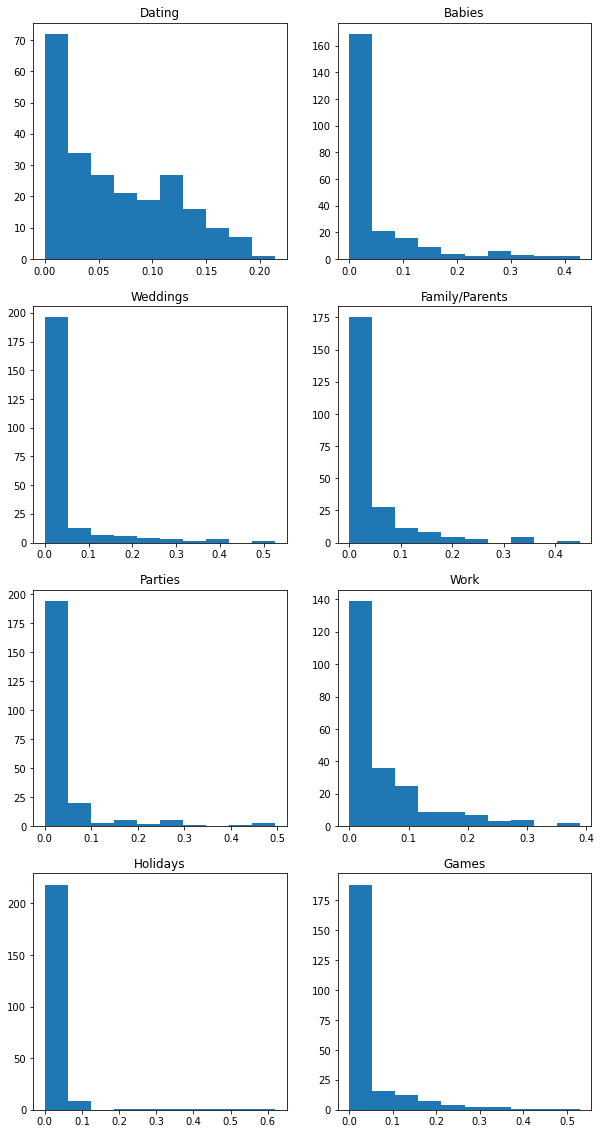

In [46]:
plt.figure(figsize=(10,20))
plt.subplot(4, 2, 1)
plt.title('Dating')
plt.hist(Modeling_topics.Dating)
plt.subplot(4, 2, 2)
plt.title('Babies')
plt.hist(Modeling_topics.Babies)
plt.subplot(4, 2, 3)
plt.title('Weddings')
plt.hist(Modeling_topics.Weddings)
plt.subplot(4, 2, 4)
plt.title('Family/Parents')
plt.hist(Modeling_topics['Family/Parents'])
plt.subplot(4, 2, 5)
plt.title('Parties')
plt.hist(Modeling_topics.Parties)
plt.subplot(4, 2, 6)
plt.title('Work')
plt.hist(Modeling_topics.Work)
plt.subplot(4, 2, 7)
plt.title('Holidays')
plt.hist(Modeling_topics.Holidays)
plt.subplot(4, 2, 8)
plt.title('Games')
plt.hist(Modeling_topics.Games)

#### Same as above but gets rid of the really low values|

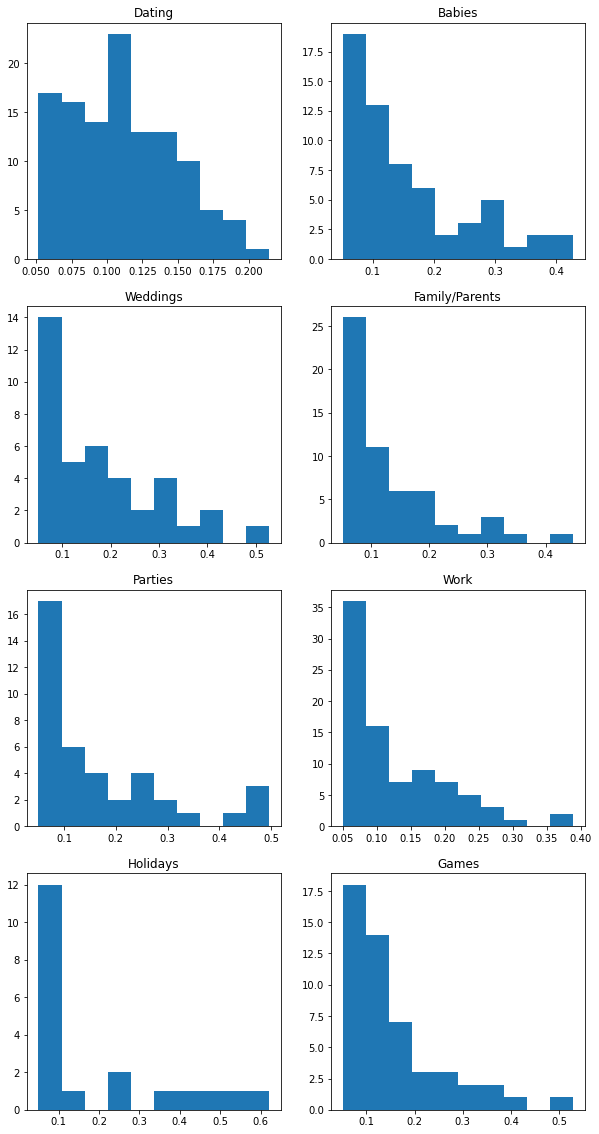

In [47]:
plt.figure(figsize=(10,20))
plt.subplot(4, 2, 1)
plt.title('Dating')
plt.hist(Modeling_topics[Modeling_topics['Dating']> 0.05].Dating)
plt.subplot(4, 2, 2)
plt.title('Babies')
plt.hist(Modeling_topics[Modeling_topics['Babies']> 0.05].Babies)
plt.subplot(4, 2, 3)
plt.title('Weddings')
plt.hist(Modeling_topics[Modeling_topics['Weddings']> 0.05].Weddings)
plt.subplot(4, 2, 4)
plt.title('Family/Parents')
plt.hist(Modeling_topics[Modeling_topics['Family/Parents']>0.05]['Family/Parents'])
plt.subplot(4, 2, 5)
plt.title('Parties')
plt.hist(Modeling_topics[Modeling_topics['Parties']> 0.05].Parties)
plt.subplot(4, 2, 6)
plt.title('Work')
plt.hist(Modeling_topics[Modeling_topics['Work']> 0.05].Work)
plt.subplot(4, 2, 7)
plt.title('Holidays')
plt.hist(Modeling_topics[Modeling_topics['Holidays']> 0.05].Holidays)
plt.subplot(4, 2, 8)
plt.title('Games')
plt.hist(Modeling_topics[Modeling_topics['Games']> 0.05].Games)
plt.savefig('MVP.png')

Changing the format of the plots for the MVP

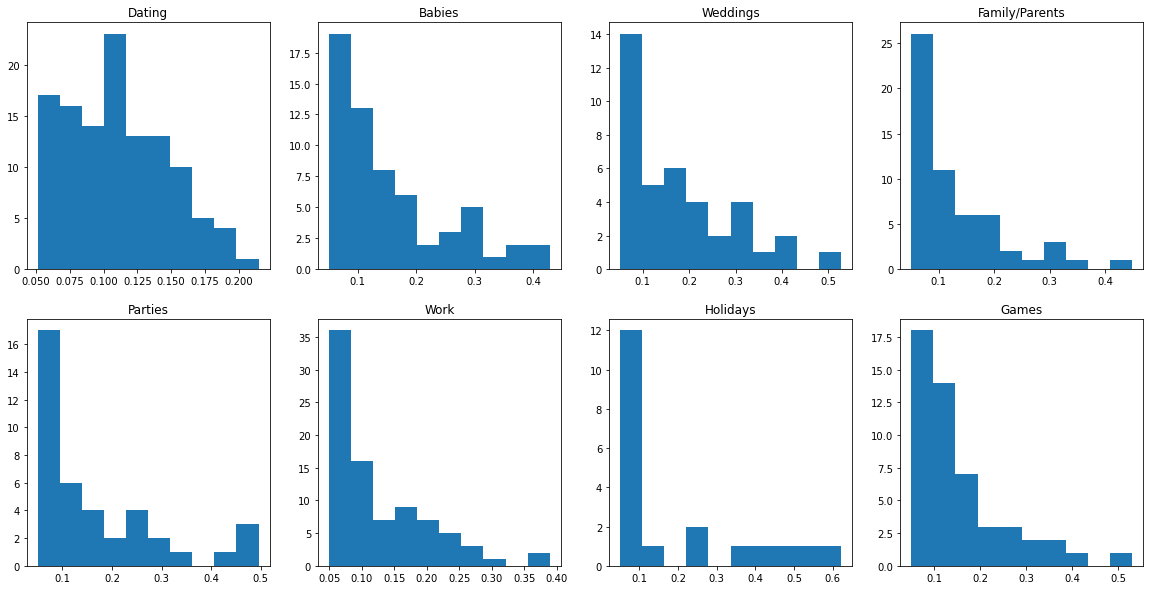

In [48]:
plt.figure(figsize=(20,10))
plt.subplot(2, 4, 1)
plt.title('Dating')
plt.hist(Modeling_topics[Modeling_topics['Dating']> 0.05].Dating)
plt.subplot(2, 4, 2)
plt.title('Babies')
plt.hist(Modeling_topics[Modeling_topics['Babies']> 0.05].Babies)
plt.subplot(2, 4, 3)
plt.title('Weddings')
plt.hist(Modeling_topics[Modeling_topics['Weddings']> 0.05].Weddings)
plt.subplot(2, 4, 4)
plt.title('Family/Parents')
plt.hist(Modeling_topics[Modeling_topics['Family/Parents']>0.05]['Family/Parents'])
plt.subplot(2, 4, 5)
plt.title('Parties')
plt.hist(Modeling_topics[Modeling_topics['Parties']> 0.05].Parties)
plt.subplot(2, 4, 6)
plt.title('Work')
plt.hist(Modeling_topics[Modeling_topics['Work']> 0.05].Work)
plt.subplot(2, 4, 7)
plt.title('Holidays')
plt.hist(Modeling_topics[Modeling_topics['Holidays']> 0.05].Holidays)
plt.subplot(2, 4, 8)
plt.title('Games')
plt.hist(Modeling_topics[Modeling_topics['Games']> 0.05].Games)
plt.savefig('MVP_T.png')

## Starting to Cluster

#### Creating a dataframe of only the topics

In [49]:
Cluster_topics = Modeling_topics[['Dating', 'Babies', 'Weddings', 'Family/Parents', 'Parties', 'Work', 'Holidays', 'Games']]

In [50]:
Cluster_topics

Dating   Babies  Weddings  Family/Parents  Parties     Work  Holidays  \
0    0.10797  0.00634   0.03558         0.06151  0.00000  0.01500   0.01895   
1    0.02018  0.07570   0.00819         0.11043  0.00000  0.11013   0.00000   
2    0.07182  0.00000   0.00000         0.08638  0.02319  0.01625   0.00000   
3    0.07090  0.01534   0.00234         0.06950  0.06469  0.02484   0.00500   
4    0.16517  0.00057   0.00000         0.00000  0.00172  0.00000   0.00000   
..       ...      ...       ...             ...      ...      ...       ...   
229  0.02238  0.16760   0.00000         0.09506  0.00000  0.10206   0.00000   
230  0.00000  0.00000   0.00000         0.02079  0.00000  0.38889   0.00000   
231  0.00000  0.00000   0.00000         0.00000  0.00000  0.38409   0.01724   
232  0.03124  0.14752   0.01264         0.00000  0.07980  0.05500   0.03149   
233  0.03976  0.18524   0.00162         0.01732  0.00000  0.00000   0.00000   

       Games  
0    0.01364  
1    0.00266  
2    0.05296  
3    0.10185  
4    0.00000  
..       ...  
229  0.00791  
230  0.00000  
231  0.00000  
232  0.02226  
233  0.14349  

[234 rows x 8 columns]

## Actually starting to cluster

In [51]:
import pandas as pd
import seaborn as sns


from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

#### Creating an Inertia Graph to determine the correct number of Clusters

In [52]:
inertia = []
for i in range(1,15):
    num_clusters = i
    kmi = KMeans(n_clusters=num_clusters,n_init=100)
    kmi.fit(Cluster_topics)
    inertia.append(kmi.inertia_)

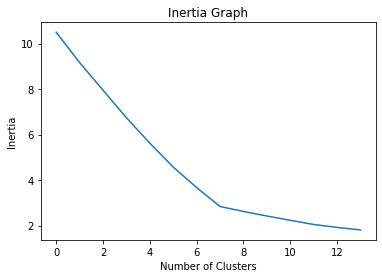

In [53]:
plt.plot(inertia)
plt.title('Inertia Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.savefig('inertia.png')

#### This told me that 7 is the superior number of clusters for this data

In [82]:
num_clusters = 7
km = KMeans(n_clusters=num_clusters,n_init=100, random_state=100) # n_init, number of times the K-mean algorithm will run
km.fit(Cluster_topics)
#display_cluster(Topics,km,num_clusters)

KMeans(n_clusters=7, n_init=100, random_state=100)

In [83]:
km.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 1, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 3, 1, 0, 0, 5, 0, 4, 6, 0, 0, 0, 0, 0, 0, 6, 2,
       6, 3, 0, 4, 0, 0, 0, 6, 2, 0, 0, 0, 2, 5, 6, 3, 0, 0, 0, 0, 0, 0,
       0, 6, 0, 2, 0, 0, 2, 0, 0, 6, 0, 0, 3, 0, 5, 6, 5, 1, 2, 2, 0, 2,
       3, 0, 1, 2, 4, 0, 3, 4, 4, 0, 0, 1, 0, 0, 0, 3, 0, 0, 2, 0, 0, 6,
       0, 3, 0, 6, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 5, 0,
       6, 3, 0, 6, 0, 0, 0, 0, 6, 6, 4, 2, 0, 0, 4, 4, 0, 6, 0, 4, 4, 2,
       0, 5, 0, 6, 0, 3, 0, 4, 4, 0, 4, 4, 0, 4, 4, 4, 1, 1, 1, 0, 0, 0,
       1, 3, 2, 2, 0, 2, 0, 1, 0, 0, 1, 4, 6, 1, 6, 1, 1, 1, 1, 1, 6, 0,
       3, 0, 0, 1, 2, 5, 1, 3, 0, 0, 6, 6, 0, 2, 6, 3, 6, 0, 0, 0, 0, 0,
       3, 2, 0, 4, 2, 1, 6, 3, 4, 1, 6, 6, 1, 1], dtype=int32)

### Creating a new dataframe to add the cluster labels to

In [84]:
clusters = Topics.copy()

In [85]:
clusters['clusters'] = km.labels_

##### Cluster centers to help understand which of the clusters best represents which topics

Clusters | Topics
-------- | ------
Zero | Dating
One | Babies
Two | Games
Three | Parties
Four | Weddings
Five | Holidays
Six | Work


###### Clusters
0. Dating
1. Babies
2. Games
3. Parties
4. Weddings
5. Holidays
6. Work

** All Have a bit of Family, just not as much as they have the other parts, dating being the one with the most family

In [86]:
km.cluster_centers_

array([[1.00601478e-01, 2.44513913e-02, 1.48373913e-02, 4.55653913e-02,
        1.39146087e-02, 3.39549565e-02, 1.15812174e-02, 1.99121739e-02],
       [1.57544000e-02, 2.50829200e-01, 1.56348000e-02, 3.37608000e-02,
        1.32104000e-02, 2.35028000e-02, 7.84520000e-03, 2.31884000e-02],
       [3.19331818e-02, 3.27418182e-02, 5.97090909e-03, 3.88131818e-02,
        8.39227273e-03, 2.08004545e-02, 7.22272727e-03, 2.45663636e-01],
       [2.88688235e-02, 2.65500000e-02, 1.21347059e-02, 2.31423529e-02,
        2.85739412e-01, 3.56705882e-02, 9.14588235e-03, 2.11058824e-02],
       [2.50630000e-02, 1.77750000e-02, 2.61312500e-01, 3.90960000e-02,
        1.96845000e-02, 2.80565000e-02, 5.95000000e-03, 9.10150000e-03],
       [2.11014286e-02, 3.75714286e-04, 5.53714286e-03, 3.70685714e-02,
        1.12728571e-02, 2.80614286e-02, 4.10394286e-01, 1.43971429e-02],
       [3.15282143e-02, 1.73539286e-02, 7.43928571e-03, 1.76817857e-02,
        1.60278571e-02, 2.18958571e-01, 6.48214286e-03, 1.

In [87]:
clusters

quote  season  \
0    There's nothing to tell! He's just some guy I ...     1.0   
1    What you guys don't understand is, for us, kis...     1.0   
2    (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...     1.0   
3    Alright. Phoebe? Okay, okay. If I were omnipot...     1.0   
4    Would you let it go? It's not that big a deal....     1.0   
..                                                 ...     ...   
229  Hi Hey! Hi! How was the honeymoon? Phoebe; Oh,...    10.0   
230  (raising his glass) Thank you guys for having ...    10.0   
231  Previously on Friends... How did the job stuff...    10.0   
232  All right, all right, all right, let's play on...    10.0   
233  Previously on Friends. Erica, are you okay? Ye...    10.0   

     episode_number   Dating   Babies  Weddings  Family/Parents  Parties  \
0               1.0  0.10797  0.00634   0.03558         0.06151  0.00000   
1               2.0  0.02018  0.07570   0.00819         0.11043  0.00000   
2               3.0  0.07182  0.00000   0.00000         0.08638  0.02319   
3               4.0  0.07090  0.01534   0.00234         0.06950  0.06469   
4               5.0  0.16517  0.00057   0.00000         0.00000  0.00172   
..              ...      ...      ...       ...             ...      ...   
229            13.0  0.02238  0.16760   0.00000         0.09506  0.00000   
230            14.0  0.00000  0.00000   0.00000         0.02079  0.00000   
231            15.0  0.00000  0.00000   0.00000         0.00000  0.00000   
232            16.0  0.03124  0.14752   0.01264         0.00000  0.07980   
233            17.0  0.03976  0.18524   0.00162         0.01732  0.00000   

        Work  Holidays    Games  clusters  
0    0.01500   0.01895  0.01364         0  
1    0.11013   0.00000  0.00266         0  
2    0.01625   0.00000  0.05296         0  
3    0.02484   0.00500  0.10185         0  
4    0.00000   0.00000  0.00000         0  
..       ...       ...      ...       ...  
229  0.10206   0.00000  0.00791         1  
230  0.38889   0.00000  0.00000         6  
231  0.38409   0.01724  0.00000         6  
232  0.05500   0.03149  0.02226         1  
233  0.00000   0.00000  0.14349         1  

[234 rows x 12 columns]

In [88]:
len(clusters[clusters['clusters'] == 0])

115

#### Cluster Zero is really large, so I wanted to see if there were separate Clusters inside of Cluster Zero

In [89]:
cluster_0 = clusters[clusters['clusters'] == 0]

In [90]:
km0 = KMeans(n_clusters=2,n_init=100)
km0.fit(cluster_0[['Dating', 'Babies', 'Weddings', 'Family/Parents', 'Parties', 'Work', 'Holidays', 'Games']])

KMeans(n_clusters=2, n_init=100)

In [91]:
km0.labels_

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int32)

In [92]:
cluster_0['labels'] = km0.labels_

<ipython-input-92-8bc6ccb4698b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0['labels'] = km0.labels_


Cluster Zero Clusters:
0. Dating
1. Family

In [93]:
km0.cluster_centers_

array([[0.11372657, 0.02389303, 0.01690727, 0.01536495, 0.01556333,
        0.03519949, 0.00972152, 0.02178253],
       [0.01939   , 0.02790625, 0.00203   , 0.23243063, 0.00371313,
        0.02625438, 0.02308813, 0.00833937]])

In [94]:
cluster_0

quote  season  \
0    There's nothing to tell! He's just some guy I ...     1.0   
1    What you guys don't understand is, for us, kis...     1.0   
2    (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...     1.0   
3    Alright. Phoebe? Okay, okay. If I were omnipot...     1.0   
4    Would you let it go? It's not that big a deal....     1.0   
..                                                 ...     ...   
216  Shana Goldberg-Meehan & Scott Silveri Part 2 w...     9.0   
217  Oh, the way you crushed Mike at ping pong was ...    10.0   
218  Okay, Ross, I realise that you didn't expect t...    10.0   
219  So, you and Rachel tonight, huh? Yeah. It's ac...    10.0   
222  (she enters) Hey... Hey! Hi! Pheebs, what's wr...    10.0   

     episode_number   Dating   Babies  Weddings  Family/Parents  Parties  \
0               1.0  0.10797  0.00634   0.03558         0.06151  0.00000   
1               2.0  0.02018  0.07570   0.00819         0.11043  0.00000   
2               3.0  0.07182  0.00000   0.00000         0.08638  0.02319   
3               4.0  0.07090  0.01534   0.00234         0.06950  0.06469   
4               5.0  0.16517  0.00057   0.00000         0.00000  0.00172   
..              ...      ...      ...       ...             ...      ...   
216            23.0  0.16000  0.01005   0.06981         0.00000  0.00000   
217             1.0  0.21446  0.00000   0.00329         0.00000  0.03267   
218             2.0  0.05866  0.06725   0.01887         0.01983  0.01730   
219             3.0  0.14452  0.03550   0.01874         0.00129  0.00000   
222             6.0  0.05981  0.05351   0.00433         0.00380  0.01765   

        Work  Holidays    Games  clusters  labels  
0    0.01500   0.01895  0.01364         0       0  
1    0.11013   0.00000  0.00266         0       1  
2    0.01625   0.00000  0.05296         0       0  
3    0.02484   0.00500  0.10185         0       0  
4    0.00000   0.00000  0.00000         0       0  
..       ...       ...      ...       ...     ...  
216  0.02537   0.00000  0.05400         0       0  
217  0.00000   0.00000  0.00000         0       0  
218  0.03024   0.01736  0.00000         0       0  
219  0.00000   0.00012  0.01364         0       0  
222  0.11162   0.00000  0.02263         0       0  

[115 rows x 13 columns]

## Using PCA to visualize the clusters in 2-D

In [95]:
from sklearn.decomposition import PCA

#### Starting with Cluster Zero to see the separation here

In [96]:
pca0 = PCA(n_components=2)

In [97]:
pca0.fit(cluster_0[['Dating', 'Babies', 'Weddings', 'Family/Parents', 'Parties', 'Work', 'Holidays', 'Games']])

PCA(n_components=2)

In [98]:
pca0_topics =pca0.transform(cluster_0[['Dating', 'Babies', 'Weddings', 'Family/Parents', 'Parties', 'Work', 'Holidays', 'Games']])

In [99]:
pca0_df = cluster_0[['Dating', 'Babies', 'Weddings', 'Family/Parents', 'Parties', 'Work', 'Holidays', 'Games', 'clusters', 'labels']].copy()

In [100]:
pca0_df['pca_component_1'] = pca0_topics[:,0]

In [101]:
pca0_df['pca_component_2'] = pca0_topics[:,1]

In [102]:
pca0_df

Dating   Babies  Weddings  Family/Parents  Parties     Work  Holidays  \
0    0.10797  0.00634   0.03558         0.06151  0.00000  0.01500   0.01895   
1    0.02018  0.07570   0.00819         0.11043  0.00000  0.11013   0.00000   
2    0.07182  0.00000   0.00000         0.08638  0.02319  0.01625   0.00000   
3    0.07090  0.01534   0.00234         0.06950  0.06469  0.02484   0.00500   
4    0.16517  0.00057   0.00000         0.00000  0.00172  0.00000   0.00000   
..       ...      ...       ...             ...      ...      ...       ...   
216  0.16000  0.01005   0.06981         0.00000  0.00000  0.02537   0.00000   
217  0.21446  0.00000   0.00329         0.00000  0.03267  0.00000   0.00000   
218  0.05866  0.06725   0.01887         0.01983  0.01730  0.03024   0.01736   
219  0.14452  0.03550   0.01874         0.00129  0.00000  0.00000   0.00012   
222  0.05981  0.05351   0.00433         0.00380  0.01765  0.11162   0.00000   

       Games  clusters  labels  pca_component_1  pca_component_2  
0    0.01364         0       0         0.012157        -0.024682  
1    0.00266         0       1         0.089412         0.096160  
2    0.05296         0       0         0.048153        -0.008109  
3    0.10185         0       0         0.029308         0.014330  
4    0.00000         0       0        -0.064095        -0.064571  
..       ...       ...     ...              ...              ...  
216  0.05400         0       0        -0.069135        -0.028911  
217  0.00000         0       0        -0.084815        -0.095468  
218  0.00000         0       0        -0.005935         0.043005  
219  0.01364         0       0        -0.056174        -0.037158  
222  0.02263         0       0        -0.025076         0.092892  

[115 rows x 12 columns]

In [103]:
pca0_df['Clusters'] = pca0_df['labels'].map({0:'Relationships', 1:'Family'})

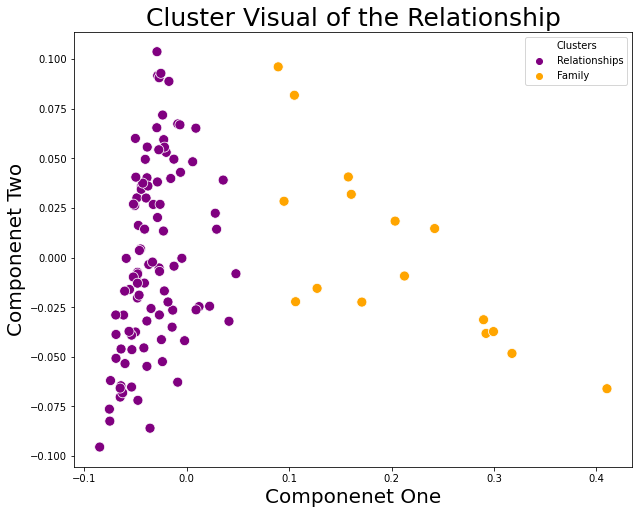

In [104]:
plt.figure(figsize=(10,8))
sns.scatterplot(pca0_df['pca_component_1'], pca0_df['pca_component_2'], hue=pca0_df['Clusters'], palette=['purple', 'orange'], s=100)
plt.title('Cluster Visual of the Relationship', fontsize=25)
plt.xlabel('Componenet One', fontsize=20)
plt.ylabel('Componenet Two', fontsize=20)
plt.savefig('clusters_of_zero.png')

## PCA for Visualization of all the Clusters

In [105]:
pca = PCA(n_components=2)

In [106]:
pca.fit(Cluster_topics)

PCA(n_components=2)

In [107]:
pca_topics =pca.transform(Cluster_topics)

In [108]:
pca_df = clusters.copy()

In [109]:
pca_df['pca_component_1'] = pca_topics[:,0]

In [110]:
pca_df['pca_component_2'] = pca_topics[:,1]

In [111]:
pca_df

quote  season  \
0    There's nothing to tell! He's just some guy I ...     1.0   
1    What you guys don't understand is, for us, kis...     1.0   
2    (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...     1.0   
3    Alright. Phoebe? Okay, okay. If I were omnipot...     1.0   
4    Would you let it go? It's not that big a deal....     1.0   
..                                                 ...     ...   
229  Hi Hey! Hi! How was the honeymoon? Phoebe; Oh,...    10.0   
230  (raising his glass) Thank you guys for having ...    10.0   
231  Previously on Friends... How did the job stuff...    10.0   
232  All right, all right, all right, let's play on...    10.0   
233  Previously on Friends. Erica, are you okay? Ye...    10.0   

     episode_number   Dating   Babies  Weddings  Family/Parents  Parties  \
0               1.0  0.10797  0.00634   0.03558         0.06151  0.00000   
1               2.0  0.02018  0.07570   0.00819         0.11043  0.00000   
2               3.0  0.07182  0.00000   0.00000         0.08638  0.02319   
3               4.0  0.07090  0.01534   0.00234         0.06950  0.06469   
4               5.0  0.16517  0.00057   0.00000         0.00000  0.00172   
..              ...      ...      ...       ...             ...      ...   
229            13.0  0.02238  0.16760   0.00000         0.09506  0.00000   
230            14.0  0.00000  0.00000   0.00000         0.02079  0.00000   
231            15.0  0.00000  0.00000   0.00000         0.00000  0.00000   
232            16.0  0.03124  0.14752   0.01264         0.00000  0.07980   
233            17.0  0.03976  0.18524   0.00162         0.01732  0.00000   

        Work  Holidays    Games  clusters  pca_component_1  pca_component_2  
0    0.01500   0.01895  0.01364         0        -0.028110         0.003620  
1    0.11013   0.00000  0.00266         0         0.021830        -0.006950  
2    0.01625   0.00000  0.05296         0        -0.012137         0.039104  
3    0.02484   0.00500  0.10185         0         0.000137         0.054488  
4    0.00000   0.00000  0.00000         0        -0.032301         0.023995  
..       ...       ...      ...       ...              ...              ...  
229  0.10206   0.00000  0.00791         1         0.104821        -0.027238  
230  0.38889   0.00000  0.00000         6        -0.132499         0.066386  
231  0.38409   0.01724  0.00000         6        -0.134040         0.066410  
232  0.05500   0.03149  0.02226         1         0.079457        -0.046394  
233  0.00000   0.00000  0.14349         1         0.175541         0.044085  

[234 rows x 14 columns]

###### Clusters
0. Dating
1. Babies
2. Games
3. Parties
4. Weddings
5. Holidays
6. Work

In [112]:
pca_df['Clusters'] = pca_df['clusters'].map({0:'Relationships', 1:'Babies', 2:'Games', 
                                           3:'Parties', 4:'Weddings', 5:'Holidays', 6:'Work'})

In [113]:
print(pca.explained_variance_ratio_)

[0.17163267 0.16013097]


In [114]:
print(pca.singular_values_)

[1.34224646 1.29649236]


#### Creating a Visual both with and without the zero cluster since it is so all encompassing 

In [115]:
pca_df_non_zero = pca_df[pca_df['clusters'] != 0]

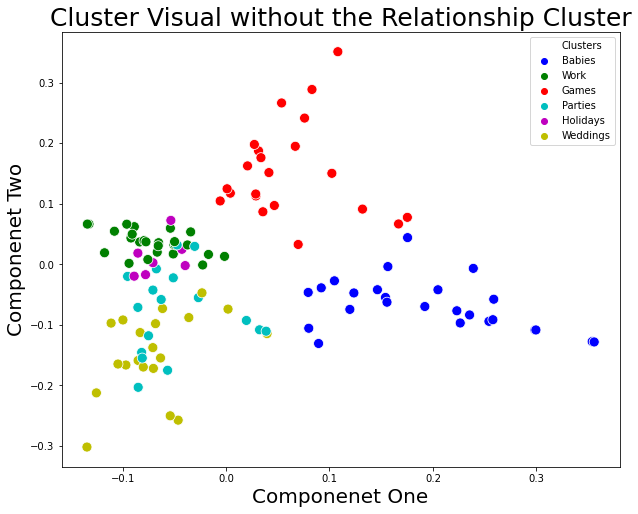

In [116]:
plt.figure(figsize=(10,8))
sns.scatterplot(pca_df_non_zero['pca_component_1'], pca_df_non_zero['pca_component_2'], hue=pca_df_non_zero['Clusters'], palette=['b', 'g', 'r', 
                                                                                                      'c', 'm', 'y'], s=100)
plt.title('Cluster Visual without the Relationship Cluster', fontsize=25)
plt.xlabel('Componenet One', fontsize=20)
plt.ylabel('Componenet Two', fontsize=20)
plt.savefig('clusters_no_zero.png')

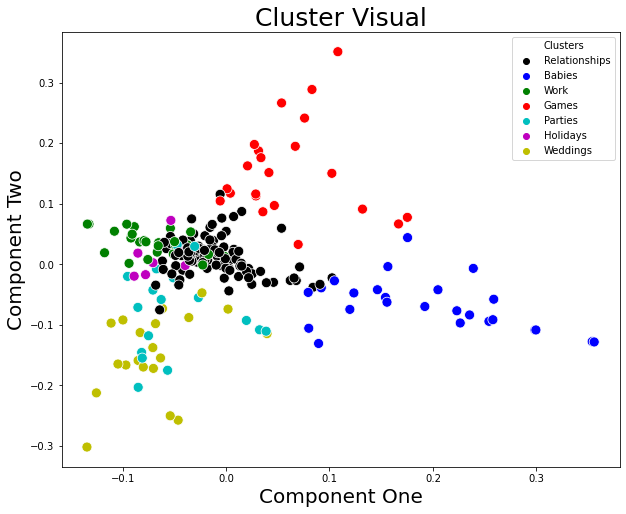

In [117]:
plt.figure(figsize=(10,8))
sns.scatterplot(pca_df['pca_component_1'], pca_df['pca_component_2'], hue=pca_df['Clusters'], palette=['k', 'b', 'g', 'r', 
                                                                                                      'c', 'm', 'y'], s=100)

plt.title('Cluster Visual', fontsize=25)
plt.xlabel('Component One', fontsize=20)
plt.ylabel('Component Two', fontsize=20)
plt.savefig('clusters_with_zero.png')

#### Using Plotly and PCA with 3 Components to show the clusters in 3 dimensional space

In [118]:
import plotly.offline as off

off.init_notebook_mode(connected=False) # allows for offline mode

import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import iplot

import pandas as pd
import numpy as np

In [119]:
pca_3 = PCA(n_components=3)

In [120]:
pca_3.fit(Cluster_topics)

PCA(n_components=3)

In [121]:
pca_3_topics =pca_3.transform(Cluster_topics)

In [122]:
pca_3_df = clusters.copy()

In [123]:
pca_3_df['pca_component_1'] = pca_3_topics[:,0]

In [124]:
pca_3_df['pca_component_2'] = pca_3_topics[:,1]

In [125]:
pca_3_df['pca_component_3'] = pca_3_topics[:,2]

In [127]:
pca_3_df['Clusters'] = pca_3_df['clusters'].map({0:'Relationships', 1:'Babies', 2:'Games', 
                                           3:'Parties', 4:'Weddings', 5:'Holidays', 6:'Work'})

In [128]:
pca_3_df

quote  season  \
0    There's nothing to tell! He's just some guy I ...     1.0   
1    What you guys don't understand is, for us, kis...     1.0   
2    (entering) Hi guys! Hey, Pheebs! Hi! Hey. Oh, ...     1.0   
3    Alright. Phoebe? Okay, okay. If I were omnipot...     1.0   
4    Would you let it go? It's not that big a deal....     1.0   
..                                                 ...     ...   
229  Hi Hey! Hi! How was the honeymoon? Phoebe; Oh,...    10.0   
230  (raising his glass) Thank you guys for having ...    10.0   
231  Previously on Friends... How did the job stuff...    10.0   
232  All right, all right, all right, let's play on...    10.0   
233  Previously on Friends. Erica, are you okay? Ye...    10.0   

     episode_number   Dating   Babies  Weddings  Family/Parents  Parties  \
0               1.0  0.10797  0.00634   0.03558         0.06151  0.00000   
1               2.0  0.02018  0.07570   0.00819         0.11043  0.00000   
2               3.0  0.07182  0.00000   0.00000         0.08638  0.02319   
3               4.0  0.07090  0.01534   0.00234         0.06950  0.06469   
4               5.0  0.16517  0.00057   0.00000         0.00000  0.00172   
..              ...      ...      ...       ...             ...      ...   
229            13.0  0.02238  0.16760   0.00000         0.09506  0.00000   
230            14.0  0.00000  0.00000   0.00000         0.02079  0.00000   
231            15.0  0.00000  0.00000   0.00000         0.00000  0.00000   
232            16.0  0.03124  0.14752   0.01264         0.00000  0.07980   
233            17.0  0.03976  0.18524   0.00162         0.01732  0.00000   

        Work  Holidays    Games  clusters  pca_component_1  pca_component_2  \
0    0.01500   0.01895  0.01364         0        -0.028110         0.003620   
1    0.11013   0.00000  0.00266         0         0.021830        -0.006950   
2    0.01625   0.00000  0.05296         0        -0.012137         0.039104   
3    0.02484   0.00500  0.10185         0         0.000137         0.054488   
4    0.00000   0.00000  0.00000         0        -0.032301         0.023995   
..       ...       ...      ...       ...              ...              ...   
229  0.10206   0.00000  0.00791         1         0.104821        -0.027238   
230  0.38889   0.00000  0.00000         6        -0.132499         0.066386   
231  0.38409   0.01724  0.00000         6        -0.134040         0.066410   
232  0.05500   0.03149  0.02226         1         0.079457        -0.046394   
233  0.00000   0.00000  0.14349         1         0.175541         0.044085   

     pca_component_3       Clusters  
0          -0.037578  Relationships  
1           0.000843  Relationships  
2          -0.009494  Relationships  
3           0.017101  Relationships  
4          -0.008279  Relationships  
..               ...            ...  
229         0.015142         Babies  
230         0.065610           Work  
231         0.067607           Work  
232         0.066721         Babies  
233        -0.016242         Babies  

[234 rows x 16 columns]

In [129]:
data = []
#clusters_list = []
colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(87,15,7)', 'rgb(57,170,4)', 'rgb(177,75,174)', 
         'rgb(47,15,174)', 'rgb(117,75,174)'] # set our dot colors

for i in range(len(pca_3_df['Clusters'].unique())): # allows us to split our data into three distinct groups
    cluster = pca_3_df['Clusters'].unique()[i]
    color = colors[i]
    x = pca_3_df[ pca_3_df['Clusters'] == cluster ]['pca_component_1']
    y = pca_3_df[ pca_3_df['Clusters'] == cluster ]['pca_component_2']
    z = pca_3_df[ pca_3_df['Clusters'] == cluster ]['pca_component_3']
    
    trace = dict(  # trace is how we "trace" or draw our data on the canvas
        name = cluster,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=3, color=color, line=dict(width=0) ) )
    data.append( trace )

layout = dict( # we modify our canvas here, including initial layout and styles
    width=800,
    height=550,
    autosize=False,
    title='PCA Clusters',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Component_1',  # set titles, very important
            titlefont=dict(
            family='Courier New',
            size=14,
            color='#2f2f2f'),  # we can use hex, rgba, or other color variants
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Component_2',  # set titles, very important
            titlefont=dict(
            family='Courier New',
            size=14,
            color='#4f4f4f'),
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Component_3',  # set titles, very important
            titlefont=dict(
            family='Courier New',
            size=14,
            color='#7f7f7f'),
        ),
        aspectratio = dict( x=1, y=1, z=1 ), # we can compress large dimensions this way
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout) # this finally compiles our figure

# run locally in notebook
iplot(fig)


###### Clusters
0. Dating
1. Babies
2. Games
3. Parties
4. Weddings
5. Holidays
6. Work

## Looking at each character by season

Fitting them to the tfidf, nmf, and kmeans from above to see how each character falls into the topics created

In [130]:
character = pd.read_csv('Friends_Seasons_Characters.csv')

In [131]:
character.drop('Unnamed: 0', axis=1, inplace=True)

In [132]:
Monica = character[character['author'] == 'Monica']

In [133]:
Rachel = character[character['author'] == 'Rachel']

In [134]:
Phoebe = character[character['author'] == 'Phoebe']

In [135]:
Chandler = character[character['author'] == 'Chandler']

In [136]:
Ross = character[character['author'] == 'Ross']

In [137]:
Joey = character[character['author'] == 'Joey']

In [138]:
monica_clean = cleaning_function(Monica['quote'])

In [139]:
monica_tfidf2 = tfidf2.transform(monica_clean)

In [140]:
monica_clean

0     theres nothing hes guy work everybody date peo...
6     im airport shes ross guys hair cut expression ...
12    i drain richards hair weird i drain hair god r...
18    shoot soda ennnh ow its miles damn hurt nothi...
24    hey i were ststill london meet minutes dont ...
30    vegas youre chandler gon heart yes yknow bac...
36    im im gon i im talk huh dont yeaah fiancee...
42    guys anybody i joey party please anything does...
48    hi hey whos aunt liddys dollars isnt baby c...
54    way pong wan pillowcase head everything walls ...
Name: quote, dtype: object

In [141]:
doc_topic_char = nmf_model2.transform(monica_tfidf2)

In [142]:
mon = pd.DataFrame(doc_topic_char.round(5),
             index = range(10))
mon

0        1        2        3        4        5        6        7
0  0.14131  0.04644  0.02220  0.14970  0.02910  0.03201  0.01283  0.08492
1  0.11004  0.02900  0.00382  0.13706  0.16093  0.06648  0.03982  0.05857
2  0.15970  0.03237  0.00000  0.06701  0.02292  0.03855  0.05203  0.14762
3  0.06117  0.04215  0.03809  0.08852  0.05851  0.11265  0.03135  0.16323
4  0.16739  0.03205  0.05260  0.01363  0.07487  0.06603  0.05090  0.05605
5  0.14695  0.05391  0.02983  0.07633  0.03854  0.07133  0.11213  0.00841
6  0.01611  0.01200  0.45580  0.11798  0.03668  0.02059  0.04133  0.00180
7  0.05383  0.21736  0.08514  0.00594  0.11864  0.04692  0.04962  0.08267
8  0.07174  0.25541  0.01971  0.00000  0.05282  0.13887  0.07071  0.06987
9  0.01327  0.24112  0.09828  0.01670  0.07382  0.09735  0.01309  0.05166

In [143]:
rachel_clean = cleaning_function(Rachel['quote'])

In [144]:
rachel_tfidf2 = tfidf2.transform(rachel_clean)

In [145]:
doc_topic_char = nmf_model2.transform(rachel_tfidf2)

In [146]:
rach = pd.DataFrame(doc_topic_char.round(5),
             index = range(10))
rach

0        1        2        3        4        5        6        7
0  0.12577  0.04914  0.02803  0.09311  0.05849  0.10678  0.03232  0.06466
1  0.18854  0.00000  0.03503  0.12608  0.07344  0.02730  0.04190  0.00000
2  0.17708  0.02080  0.00948  0.00942  0.05353  0.11576  0.01542  0.06640
3  0.09664  0.04603  0.02642  0.03562  0.06816  0.10419  0.01754  0.17301
4  0.16027  0.08219  0.04296  0.00174  0.07168  0.10262  0.00399  0.02830
5  0.16289  0.02341  0.04405  0.05100  0.01615  0.15364  0.08105  0.01997
6  0.14022  0.02123  0.15954  0.00207  0.05822  0.11592  0.02924  0.00701
7  0.06756  0.42059  0.03654  0.01225  0.04019  0.04309  0.00047  0.00744
8  0.09858  0.19189  0.00000  0.02009  0.12071  0.09916  0.03986  0.05218
9  0.05476  0.12012  0.04589  0.03735  0.20684  0.13032  0.00193  0.02353

In [147]:
phoebe_clean = cleaning_function(Phoebe['quote'])

In [148]:
phoebe_tfidf2 = tfidf2.transform(phoebe_clean)

In [149]:
doc_topic_char = nmf_model2.transform(phoebe_tfidf2)

In [150]:
pheebs = pd.DataFrame(doc_topic_char.round(5),
             index = range(10))
pheebs

0        1        2        3        4        5        6        7
0  0.13946  0.04618  0.00000  0.12352  0.03753  0.06567  0.01718  0.03574
1  0.14410  0.02588  0.00857  0.19845  0.03718  0.05752  0.02765  0.00000
2  0.12899  0.00140  0.00000  0.14086  0.03660  0.09790  0.06113  0.06269
3  0.00000  0.21488  0.06419  0.15483  0.06992  0.08440  0.05382  0.04687
4  0.12525  0.03945  0.01425  0.04934  0.14860  0.06877  0.03708  0.05954
5  0.15494  0.02783  0.02173  0.03192  0.01830  0.13846  0.02340  0.05646
6  0.10206  0.01591  0.14066  0.04346  0.05057  0.10588  0.06084  0.01630
7  0.06018  0.19318  0.07209  0.04611  0.06312  0.04559  0.02158  0.07597
8  0.12665  0.06973  0.02619  0.04796  0.10265  0.11392  0.04100  0.04888
9  0.05259  0.09284  0.22990  0.02604  0.09086  0.08545  0.00521  0.07181

In [151]:
chandler_clean = cleaning_function(Chandler['quote'])

In [152]:
chandler_tfidf2 = tfidf2.transform(chandler_clean)

In [153]:
doc_topic_char = nmf_model2.transform(chandler_tfidf2)

In [154]:
chan = pd.DataFrame(doc_topic_char.round(5),
             index = range(10))
chan

0        1        2        3        4        5        6        7
0  0.16521  0.01137  0.00000  0.10703  0.04117  0.05259  0.03298  0.07654
1  0.13071  0.01763  0.00247  0.08677  0.10352  0.10490  0.04121  0.06788
2  0.15096  0.03750  0.00330  0.07070  0.08531  0.10804  0.03291  0.08430
3  0.09957  0.04948  0.02936  0.01490  0.10503  0.08837  0.05857  0.19636
4  0.15890  0.04051  0.04425  0.02796  0.03583  0.07719  0.04079  0.07967
5  0.12500  0.01975  0.04452  0.02948  0.02183  0.18580  0.04785  0.12397
6  0.04732  0.00626  0.32474  0.02196  0.05494  0.03339  0.10750  0.04236
7  0.03974  0.13997  0.08820  0.00000  0.08263  0.08510  0.03082  0.10555
8  0.09749  0.14027  0.04028  0.00136  0.00773  0.13442  0.17797  0.08507
9  0.03123  0.12274  0.13056  0.02831  0.07913  0.10146  0.03801  0.10965

In [155]:
ross_clean = cleaning_function(Ross['quote'])

In [156]:
ross_tfidf2 = tfidf2.transform(ross_clean)

In [157]:
doc_topic_char = nmf_model2.transform(ross_tfidf2)

In [158]:
ros = pd.DataFrame(doc_topic_char.round(5),
             index = range(10))
ros

0        1        2        3        4        5        6        7
0  0.11738  0.21003  0.00000  0.13497  0.03306  0.00000  0.02082  0.06890
1  0.12420  0.05030  0.01956  0.13108  0.08804  0.06755  0.03126  0.02363
2  0.17786  0.00391  0.00000  0.07219  0.07193  0.08287  0.05194  0.11870
3  0.11351  0.00769  0.10071  0.11050  0.13217  0.02996  0.03284  0.10972
4  0.16577  0.01551  0.03546  0.06113  0.04799  0.08981  0.02583  0.09085
5  0.14072  0.00698  0.01984  0.06074  0.00413  0.11923  0.05740  0.09143
6  0.07365  0.00345  0.13349  0.12631  0.03658  0.05983  0.17358  0.01829
7  0.08181  0.31082  0.05932  0.04071  0.02162  0.00000  0.00927  0.04750
8  0.15200  0.13664  0.01049  0.03419  0.02153  0.11592  0.03881  0.03100
9  0.09936  0.07581  0.08326  0.01375  0.07492  0.11451  0.04452  0.09646

In [159]:
joey_clean = cleaning_function(Joey['quote'])

In [160]:
joey_tfidf2 = tfidf2.transform(joey_clean)

In [161]:
doc_topic_char = nmf_model2.transform(joey_tfidf2)

In [162]:
joe = pd.DataFrame(doc_topic_char.round(5),
             index = range(10))
joe

0        1        2        3        4        5        6        7
0  0.12463  0.12062  0.00000  0.14778  0.04225  0.02798  0.00000  0.05089
1  0.11497  0.02267  0.00060  0.07744  0.01712  0.17214  0.00735  0.07542
2  0.12285  0.03058  0.00000  0.03295  0.01298  0.16572  0.04482  0.13764
3  0.06356  0.08427  0.02347  0.05014  0.14599  0.05700  0.05521  0.19885
4  0.11767  0.05121  0.04023  0.01703  0.03011  0.13706  0.02275  0.12053
5  0.10983  0.00150  0.03439  0.03312  0.05100  0.21552  0.02250  0.09057
6  0.10552  0.01326  0.18919  0.03306  0.01218  0.14861  0.01671  0.01896
7  0.11103  0.23035  0.04747  0.03188  0.05805  0.05943  0.00214  0.08696
8  0.13819  0.05008  0.00000  0.02001  0.04547  0.14322  0.01577  0.13774
9  0.07310  0.11938  0.04296  0.04426  0.01593  0.15620  0.00000  0.06410

In [163]:
mon_clusters = km.predict(mon)
mon_clusters

array([0, 0, 0, 2, 0, 0, 4, 1, 1, 1], dtype=int32)

In [164]:
rach_clusters = km.predict(rach)
rach_clusters

array([0, 0, 0, 2, 0, 0, 0, 1, 1, 3], dtype=int32)

In [165]:
pheebs_clusters = km.predict(pheebs)
pheebs_clusters

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 4], dtype=int32)

In [166]:
chan_clusters = km.predict(chan)
chan_clusters

array([0, 0, 0, 2, 0, 6, 4, 1, 0, 0], dtype=int32)

In [167]:
ross_clusters = km.predict(ros)
ross_clusters

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [168]:
joey_clusters = km.predict(joe)
joey_clusters

array([0, 6, 6, 2, 0, 6, 4, 1, 0, 6], dtype=int32)

###### Clusters
0. Dating
1. Babies
2. Games
3. Parties
4. Weddings
5. Holidays
6. Work

** All Have a bit of Family, just not as much as they have the other parts, dating being the one with the most family

## Creating a Recommendation Function in Python to Recommend similar episodes

In [175]:
from sklearn.metrics import pairwise_distances

In [177]:
def find_closest(index, num):
    '''Finds the closest episode, using Cosine Distances to the
    episode of interest
    Inputs: Index of Episode of Interest, Number of closest episodes to return
    Returns: list of indexes of closest episodes'''
    ordered_array = pairwise_distances(np.array(Cluster_topics.loc[index]).reshape(1, -1)
                                       ,doc_topic2,metric='cosine').argsort()
    top = []
    for i in range(1, num+1):
        top.append(ordered_array[0][i])
    return top

In [178]:
find_closest(0, 5)

[60, 101, 123, 27, 18]

In [183]:
def lower(text):
    'Takes in text as in input and lowercases it'
    text = text.lower()
    return text

Inputing a new dataframe that has all of the episode names

In [185]:
names = pd.read_csv('Friends_Episodes_More.csv')

In [186]:
names = names[['Episode_Title']]

In [187]:
names

Episode_Title
0                                             Pilot
1              The One with the Sonogram at the End
2                            The One with the Thumb
3                The One with George Stephanopoulos
4    The One with the East German Laundry Detergent
..                                              ...
229                The One Where Joey Speaks French
230                  The One with Princess Consuela
231                      The One Where Estelle Dies
232          The One with Rachel's Going Away Party
233                                    The Last One

[234 rows x 1 columns]

In [188]:
names_lower = names['Episode_Title'].map(lower)

In [189]:
def title_to_index(title):
    '''Takes a Friends Episode Title and changes it to an index to input into a function'''
    title = title.lower()
    idx = names_lower[names_lower == title].index[0]
    return idx

In [190]:
def find_title(title, num):
    '''Finds the titles associated with the closest 
    Uses find_closest, so the inputs can be the same, 
    but instead returns titles not indexes so it is more user friendly'''
    index = title_to_index(title)
    idx = find_closest(index, num)
    titles = []
    for i in idx:
        titles.append(names.loc[i][0])
    return titles

In [191]:
find_title('the one with the kips',5)

['The One with the Evil Orthodontist',
 'The One with All the Cheesecakes',
 'The One with the Vows',
 'Pilot',
 "The One with Joey's Award"]

In [192]:
find_title('The one with all the kissing', 3)

['The One After Ross Says Rachel',
 'The One with the Vows',
 'The One with All the Cheesecakes']

In [193]:
find_title('The one where everybody finds out', 3)

['The One with the East German Laundry Detergent',
 'The One Where Ross Finds Out',
 'The One with the Proposal']

### Using the function `find_title` you can now input a title and the number of titles to return and it will give you that many recommendations for the similar episodes

## Looking at the seasons overall to gain themes and clusters, not just by character

In [195]:
characters = pd.read_csv('Full_Friends_Lines.csv')

In [196]:
characters.drop('Unnamed: 0', axis=1, inplace=True)

In [197]:
characters

author                                              quote  season  \
0       Monica  There's nothing to tell! He's just some guy I ...     1.0   
1         Joey  C'mon, you're going out with the guy! There's ...     1.0   
2       Rachel  Oh God Monica hi! Thank God! I just went to yo...     1.0   
3         Ross  (mortified) Hi. I just feel like someone reach...     1.0   
4       Phoebe  Wait, does he eat chalk? Just, 'cause, I don't...     1.0   
...        ...                                                ...     ...   
1399      Joey  Hey! It's my house-warming present for Monica ...    10.0   
1400    Rachel  So if you think I didn't say goodbye to you be...    10.0   
1401      Ross  Rach! Hey. Oh. This was amazing. Yeah, well, t...    10.0   
1402    Phoebe  Morning. What's that? It's a baby chick and du...    10.0   
1403  Chandler  Relax! We'll just get her some antacids. Oh my...    10.0   

      episode_number  
0                1.0  
1                1.0  
2                1.0  
3                1.0  
4                1.0  
...              ...  
1399            17.0  
1400            17.0  
1401            17.0  
1402            17.0  
1403            17.0  

[1404 rows x 4 columns]

In [198]:
data = characters.copy()

#### Creating a new DataFrame for each season

In [199]:
s1 = data[(data['season'] == 1)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [200]:
s2 = data[(data['season'] == 2)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [201]:
s3 = data[(data['season'] == 3)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [202]:
s4 = data[(data['season'] == 4)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [203]:
s5 = data[(data['season'] == 5)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [204]:
s6 = data[(data['season'] == 6)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [205]:
s7 = data[(data['season'] == 7)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [206]:
s8 = data[(data['season'] == 8)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [207]:
s9 = data[(data['season'] == 9)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [208]:
s10 = data[(data['season'] == 10)][['quote', 'season']].groupby('season').agg({'quote':lambda x: ' '.join(x)}).reset_index()

In [209]:
seasons = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10]

In [211]:
def combine_seasons(list_of_data):
    '''Takes a list of dataframes and combines them into one'''
    df = pd.DataFrame(columns = ['season', 'quote'])
    for season in list_of_data:
        df = pd.concat([df, season], ignore_index=True)
    return df

In [212]:
season_data = combine_seasons(seasons)

In [213]:
seasons_clean = cleaning_function(season_data['quote'])

In [214]:
seasons_tfidf2 = tfidf2.transform(seasons_clean)

In [215]:
doc_topic_seasons = nmf_model2.transform(seasons_tfidf2)

In [216]:
season = pd.DataFrame(doc_topic_seasons.round(5),
             index = seasons_clean.index)
season

0        1        2        3        4        5        6        7
0  0.21151  0.12841  0.00000  0.19682  0.06338  0.07242  0.02993  0.10207
1  0.21152  0.03717  0.01889  0.19653  0.12394  0.12990  0.04925  0.05842
2  0.23627  0.03031  0.00000  0.09872  0.07228  0.15609  0.06609  0.15808
3  0.11342  0.11891  0.07553  0.12144  0.15304  0.12365  0.06416  0.22915
4  0.22861  0.06741  0.05878  0.04316  0.10339  0.14290  0.04526  0.11331
5  0.20654  0.03067  0.04887  0.06928  0.03783  0.22543  0.08376  0.10236
6  0.12286  0.01833  0.35708  0.08800  0.06253  0.12022  0.10774  0.02588
7  0.10588  0.39328  0.09382  0.03329  0.09254  0.06628  0.02641  0.09603
8  0.17095  0.21877  0.02149  0.02913  0.08610  0.18791  0.10026  0.10652
9  0.08283  0.20376  0.16353  0.04248  0.14076  0.17724  0.02518  0.10749

In [217]:
season_labels = km.predict(season)
season_labels

array([0, 0, 0, 2, 0, 6, 4, 1, 1, 1], dtype=int32)

###### Clusters
0. Dating
1. Babies
2. Games
3. Parties
4. Weddings
5. Holidays
6. Work

## Word Clouds

In [218]:
zero = clusters[clusters['clusters'] == 0]

In [219]:
one = clusters[clusters['clusters'] == 1]

In [220]:
two = clusters[clusters['clusters'] == 2]

In [221]:
three = clusters[clusters['clusters'] == 3]

In [222]:
four = clusters[clusters['clusters'] == 4]

In [223]:
five = clusters[clusters['clusters'] == 5]

In [224]:
six = clusters[clusters['clusters'] == 6]

In [225]:
new_stop_words = ['aand', 'oh', 'like', 'ok', 'okay', 'hey', 'just', 'yeaah', 'right', 
                  'monica', 'joey', 'rachel', 'chandler', 'phoebe', 'ross', 'im', 
                 'youre', 'hes', 'shes', 'thats', 'dont', 'ill', 'ii', 'janice', 'richard', 
                 'mike', 'emma', 'emily', 'david', 'julie', 'mark',  'julies', 'saraah', 
                 'cmon', 'ya', 'uh', 'lets', 'whats', 'ow', 'aah', 'yknow', 'anything', 
                 'nothing', 'know', 'guys', 'things', 'marcel', 'barry', 'theres', 'didnt', 'bye', 'paul', 'blaah',
                 'woaah', 'jill', 'cat', 'chip', 'doctor', 'ring', 'joshua', 'lauren', 'alice', 'frank',
                 'ben', 'monkey', 'carol', 'apartment', 'lot', 'hooker', 'tape', 'tattoo', 'umm', 'ohh', 'kathy', 
                 'huh', 'um', 'cant', 'ive', 'whatre', 'theyre', 'phoebs', 'wanna', 'uhm', 'charlie', 'alright', 
                 'id', 'mikes', 'dr', 'amy', 'pheebs', 'stuff', 'tulsa', 'isnt', 'doesnt', 'whos', 'fine', 'youve', 
                 'wont', 'still', 'paolo', 'la', 'mindy', 'eddie', 'annulment', 'ralph', 'cause', 'big', 'ever', 
                 'get', 'getting', 'bob', 'susan', 'drake', 'nice', 'please', 'toe', 'dog', 'move', 'keys', 
                 'live', 'moving', 'gon', 'god', 'look', 'time', 'something', 'thing', 'thank', 'hi', 'ooh', 'andand', 
                 'let', 'tribbiani', 'way', 'sorry', 'youyou', 'thanks', 'yeah', 'well', 'think', 'go', 
                 'really', 'gonna', "i'm", 'god', 'time']

In [226]:
zero_clean = cleaning_function(zero.quote)

In [227]:
one_clean = cleaning_function(one.quote)

In [228]:
two_clean = cleaning_function(two.quote)

In [229]:
three_clean = cleaning_function(three.quote)

In [230]:
four_clean = cleaning_function(four.quote)

In [231]:
five_clean = cleaning_function(five.quote)

In [232]:
six_clean = cleaning_function(six.quote)

In [233]:
stopwordswordcloud = list(stop_words) + new_stop_words

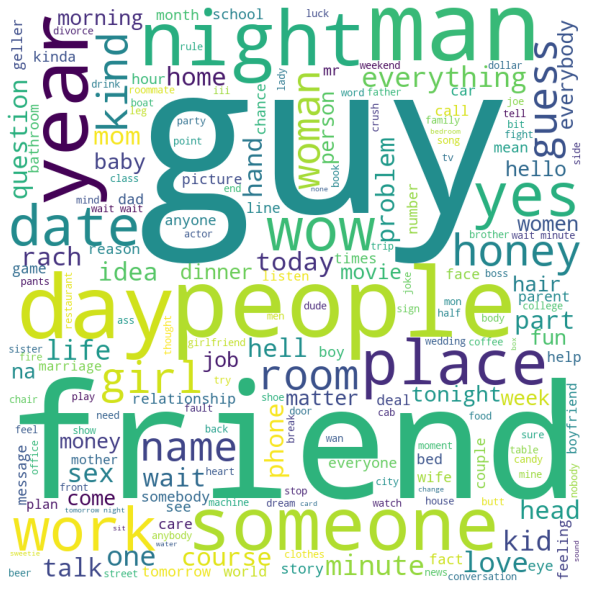

In [244]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
comment_words = ' '
tokens = [] 

# iterate through the csv file 
for row in zero_clean: 

   # typecaste each val to string 
   row = str(row) 

   # split the value 
   tokens += row.split() 

# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 

for words in tokens: 
    comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwordswordcloud, 
            min_font_size =10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('Word_Cloud.png')
plt.show() 
#plt.savefig('Word_Cloud.jpeg')

#### I did this for each of the clusters

## Attempting to Model with LDA

In [235]:
new_stop_words = ['aand', 'oh', 'like', 'ok', 'okay', 'hey', 'just', 'yeaah', 'right', 
                  'monica', 'joey', 'rachel', 'chandler', 'phoebe', 'ross', 'im', 
                 'youre', 'hes', 'shes', 'thats', 'dont', 'ill', 'ii', 'janice', 'richard', 
                 'mike', 'emma', 'emily', 'david', 'julie', 'mark',  'julies', 'saraah', 
                 'cmon', 'ya', 'uh', 'lets', 'whats', 'ow', 'aah', 'yknow', 'anything', 
                 'nothing', 'know', 'guys', 'things', 'marcel', 'barry', 'theres', 'didnt', 'bye', 'paul', 'blaah',
                 'woaah', 'jill', 'cat', 'chip', 'doctor', 'ring', 'joshua', 'lauren', 'alice', 'frank',
                 'ben', 'monkey', 'carol', 'apartment', 'lot', 'hooker', 'tape', 'tattoo', 'umm', 'ohh', 'kathy', 
                 'huh', 'um', 'cant', 'ive', 'whatre', 'theyre', 'phoebs', 'wanna', 'uhm', 'charlie', 'alright', 
                 'id', 'mikes', 'dr', 'amy', 'pheebs', 'stuff', 'tulsa', 'isnt', 'doesnt', 'whos', 'fine', 'youve', 
                 'wont', 'still', 'paolo', 'la', 'mindy', 'eddie', 'annulment', 'ralph', 'cause', 'big', 'ever', 
                 'get', 'getting', 'bob', 'susan', 'drake', 'nice', 'please', 'toe', 'dog', 'move', 'keys', 
                 'live', 'moving', 'bobby', 'heckles', 'roger', 'joseph', 'pete', 'porsche', 'greg', 'ew', 'pottery', 
                 'barn', 'exgirlfriend', 'joanna', 'robert', 'ha', 'larry', 'mona', 'bonnie', 'gavin', 'doug', 
                 'denise', 'carl', 'dina', 'tommy', 'gellers', 'michelle', 'jane', 'jason', 'chris', 'rewe', 
                 'wendy']

In [236]:
stopwords_LDA = list(stop_words) + new_stop_words

In [237]:
tfidf3 = TfidfVectorizer(stop_words=stopwords_LDA, min_df=.01, max_df=.9)

In [238]:
friends_tfidf3 = tfidf3.fit_transform(friends_clean)

In [239]:
 #gensim
from gensim import corpora, models, similarities, matutils

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim import matutils, models
import scipy.sparse

In [240]:
id2word = dict((v, k) for k, v in tfidf3.vocabulary_.items())

In [241]:

# Create the gensim corpus
corpuslda = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(friends_tfidf3.transpose()))

In [242]:

# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpuslda, num_topics=10, id2word=id2word, passes=20)

2020-08-23 13:20:37,350 : INFO : using symmetric alpha at 0.1
2020-08-23 13:20:37,353 : INFO : using symmetric eta at 0.1
2020-08-23 13:20:37,356 : INFO : using serial LDA version on this node
2020-08-23 13:20:37,362 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 234 documents, updating model once every 234 documents, evaluating perplexity every 234 documents, iterating 50x with a convergence threshold of 0.001000
2020-08-23 13:20:37,777 : INFO : -22.889 per-word bound, 7768731.3 perplexity estimate based on a held-out corpus of 234 documents with 2457 words
2020-08-23 13:20:37,778 : INFO : PROGRESS: pass 0, at document #234/234
2020-08-23 13:20:37,974 : INFO : topic #4 (0.100): 0.003*"baby" + 0.002*"game" + 0.002*"guy" + 0.002*"date" + 0.002*"wait" + 0.002*"money" + 0.002*"phone" + 0.002*"plane" + 0.002*"bag" + 0.002*"everything"
2020-08-23 13:20:37,975 : INFO : topic #7 (0.100): 0.004*"night" + 0.003*"guy" + 0.003*"date" + 0.002*"b

2020-08-23 13:20:41,029 : INFO : topic diff=0.243501, rho=0.377964
2020-08-23 13:20:41,371 : INFO : -10.708 per-word bound, 1672.6 perplexity estimate based on a held-out corpus of 234 documents with 2457 words
2020-08-23 13:20:41,372 : INFO : PROGRESS: pass 6, at document #234/234
2020-08-23 13:20:41,475 : INFO : topic #8 (0.100): 0.002*"cheesecake" + 0.002*"fries" + 0.002*"soul" + 0.002*"bike" + 0.002*"chick" + 0.002*"bath" + 0.001*"ruth" + 0.001*"assistant" + 0.001*"badge" + 0.001*"backup"
2020-08-23 13:20:41,476 : INFO : topic #7 (0.100): 0.006*"guy" + 0.005*"baby" + 0.004*"night" + 0.004*"day" + 0.004*"wait" + 0.004*"date" + 0.003*"thanks" + 0.003*"sex" + 0.003*"thank" + 0.003*"room"
2020-08-23 13:20:41,478 : INFO : topic #6 (0.100): 0.002*"honor" + 0.002*"panties" + 0.002*"maid" + 0.001*"danger" + 0.001*"beef" + 0.001*"sock" + 0.001*"parker" + 0.001*"wheel" + 0.001*"dessert" + 0.001*"freezer"
2020-08-23 13:20:41,486 : INFO : topic #2 (0.100): 0.003*"push" + 0.002*"father" + 0.002

2020-08-23 13:20:44,592 : INFO : -10.333 per-word bound, 1289.8 perplexity estimate based on a held-out corpus of 234 documents with 2457 words
2020-08-23 13:20:44,593 : INFO : PROGRESS: pass 12, at document #234/234
2020-08-23 13:20:44,670 : INFO : topic #7 (0.100): 0.006*"guy" + 0.005*"baby" + 0.004*"night" + 0.003*"day" + 0.003*"wait" + 0.003*"thanks" + 0.003*"date" + 0.003*"honey" + 0.003*"thank" + 0.003*"sex"
2020-08-23 13:20:44,671 : INFO : topic #3 (0.100): 0.002*"award" + 0.002*"eggs" + 0.002*"conference" + 0.002*"secrets" + 0.002*"bachelor" + 0.002*"lotion" + 0.002*"ginger" + 0.002*"maintenance" + 0.002*"merry" + 0.002*"heat"
2020-08-23 13:20:44,672 : INFO : topic #5 (0.100): 0.002*"pact" + 0.002*"vows" + 0.002*"jam" + 0.002*"wind" + 0.002*"lemonade" + 0.002*"breathe" + 0.002*"boobies" + 0.001*"china" + 0.001*"unit" + 0.001*"stripper"
2020-08-23 13:20:44,674 : INFO : topic #9 (0.100): 0.002*"bings" + 0.002*"prize" + 0.002*"grant" + 0.001*"review" + 0.001*"jake" + 0.001*"kate" 

2020-08-23 13:20:47,549 : INFO : PROGRESS: pass 18, at document #234/234
2020-08-23 13:20:47,676 : INFO : topic #5 (0.100): 0.003*"pact" + 0.002*"vows" + 0.002*"wind" + 0.002*"lemonade" + 0.002*"jam" + 0.002*"character" + 0.002*"boobies" + 0.002*"china" + 0.002*"breathe" + 0.001*"stripper"
2020-08-23 13:20:47,678 : INFO : topic #6 (0.100): 0.002*"panties" + 0.002*"danger" + 0.001*"sock" + 0.001*"beef" + 0.001*"wheel" + 0.001*"scotch" + 0.001*"phillips" + 0.001*"walls" + 0.001*"tip" + 0.001*"limit"
2020-08-23 13:20:47,681 : INFO : topic #4 (0.100): 0.002*"potatoes" + 0.002*"states" + 0.002*"bus" + 0.002*"pies" + 0.002*"hanukkaah" + 0.001*"backup" + 0.001*"bone" + 0.001*"balloon" + 0.001*"escape" + 0.001*"turkeys"
2020-08-23 13:20:47,689 : INFO : topic #2 (0.100): 0.003*"push" + 0.002*"gum" + 0.002*"evolution" + 0.002*"mac" + 0.001*"farm" + 0.001*"butts" + 0.001*"services" + 0.001*"poker" + 0.001*"noodles" + 0.001*"cheese"
2020-08-23 13:20:47,692 : INFO : topic #3 (0.100): 0.002*"eggs" +

In [243]:
lda.print_topics()

2020-08-23 13:20:48,144 : INFO : topic #0 (0.100): 0.003*"poker" + 0.002*"nanny" + 0.002*"breast" + 0.002*"earrings" + 0.002*"gas" + 0.002*"ho" + 0.002*"rat" + 0.002*"jacket" + 0.002*"rats" + 0.002*"dentist"
2020-08-23 13:20:48,146 : INFO : topic #1 (0.100): 0.002*"heights" + 0.001*"eyebrows" + 0.001*"tests" + 0.001*"beans" + 0.001*"digest" + 0.001*"patience" + 0.001*"ewww" + 0.001*"wenus" + 0.001*"whoo" + 0.001*"island"
2020-08-23 13:20:48,148 : INFO : topic #2 (0.100): 0.002*"push" + 0.002*"gum" + 0.002*"evolution" + 0.002*"mac" + 0.001*"farm" + 0.001*"butts" + 0.001*"services" + 0.001*"poker" + 0.001*"cheese" + 0.001*"noodles"
2020-08-23 13:20:48,150 : INFO : topic #3 (0.100): 0.002*"eggs" + 0.002*"award" + 0.002*"conference" + 0.002*"bachelor" + 0.002*"lotion" + 0.002*"ginger" + 0.002*"maintenance" + 0.002*"merry" + 0.002*"secrets" + 0.001*"advertising"
2020-08-23 13:20:48,153 : INFO : topic #4 (0.100): 0.002*"potatoes" + 0.002*"states" + 0.002*"bus" + 0.002*"pies" + 0.001*"backup"

[(0,
  '0.003*"poker" + 0.002*"nanny" + 0.002*"breast" + 0.002*"earrings" + 0.002*"gas" + 0.002*"ho" + 0.002*"rat" + 0.002*"jacket" + 0.002*"rats" + 0.002*"dentist"'),
 (1,
  '0.002*"heights" + 0.001*"eyebrows" + 0.001*"tests" + 0.001*"beans" + 0.001*"digest" + 0.001*"patience" + 0.001*"ewww" + 0.001*"wenus" + 0.001*"whoo" + 0.001*"island"'),
 (2,
  '0.002*"push" + 0.002*"gum" + 0.002*"evolution" + 0.002*"mac" + 0.001*"farm" + 0.001*"butts" + 0.001*"services" + 0.001*"poker" + 0.001*"cheese" + 0.001*"noodles"'),
 (3,
  '0.002*"eggs" + 0.002*"award" + 0.002*"conference" + 0.002*"bachelor" + 0.002*"lotion" + 0.002*"ginger" + 0.002*"maintenance" + 0.002*"merry" + 0.002*"secrets" + 0.001*"advertising"'),
 (4,
  '0.002*"potatoes" + 0.002*"states" + 0.002*"bus" + 0.002*"pies" + 0.001*"backup" + 0.001*"hanukkaah" + 0.001*"bone" + 0.001*"balloon" + 0.001*"escape" + 0.001*"turkeys"'),
 (5,
  '0.003*"pact" + 0.002*"vows" + 0.002*"wind" + 0.002*"lemonade" + 0.002*"character" + 0.002*"jam" + 0.002

#### As much as I changed these and ran them I just could not get any interpretable topics